In [1]:
'''
Original file is located at
    https://colab.research.google.com/drive/19AJ2q_43-9IRBG1fT0ztULh12OUtjL_l
'''

'\nOriginal file is located at\n    https://colab.research.google.com/drive/19AJ2q_43-9IRBG1fT0ztULh12OUtjL_l\n'

In [2]:
import os
import sys
import copy
import random
import pcgym
import optuna
import torch
import numpy as np
import gymnasium as gym
import torch.nn.functional as F
import matplotlib.pyplot as plt
from stable_baselines3 import PPO,SAC,DDPG,TD3
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
# from callback import LearningCurveCallback
from dataclasses import dataclass
from contextlib import contextmanager
from pcgym import make_env

In [3]:
# Define environment
T = 26
nsteps = 150

# Global seed for reproducibility
seed = 1490

"""
Control Club Challenge (PSE)
## 1. Control Problem
The environment used in the this problem is a Continuously Stirred Tank Reactor (CSTR) performing an exothermic reaction (A → B). The controlled variable will be the concentration of species A by manipulating the temperature of the cooling jacket. A diagram of the environment is given below.

### Problem Definition
You must design a control policy which maximises the reward defined by the square error between the state $C_A$ and its set point $C_{A,SP}$ for the environment below. There is also a disturbance to the input feed concentration $C_{A,IN}$ which happens around 9 minutes into the episode, returning again to the original value at ~18 minutes.

## 2. Challenge Environment
First define the challenge environment
"""

SP = {
    'Ca': [0.85 for i in range(int(nsteps/3))] + [0.9 for i in range(int(nsteps/3))]+ [0.87 for i in range(int(nsteps/3))],
}

disturbance = {'Caf': np.repeat([1, 1.05, 1], [nsteps//3, nsteps//3, nsteps//3])}

action_space = {
    'low': np.array([295]),
    'high':np.array([302])
}
#Continuous box observation space  Specifications (Ca,T,Ca_SP)
observation_space = {
    'low' : np.array([0.7,300,0.8]),
    'high' : np.array([1,350,0.9])
}

r_scale = {'Ca':1e3}

disturbance_space ={
  'low': np.array([1]),
  'high': np.array([1.05])
}

########################################################################################################################################################################

# Examples of reward functions that were given on the paper : https://arxiv.org/pdf/2410.22093 (Chapter 7 Reward Functions)

# Custom reward:
# Negative squared error (39): will penalize the agent for being far from the setpoint.
# However, it will penalize the agent more heavily compared to the absolute error as it moves away from the set point.

def r_squared(self,x,u,con):
    Sp_i = 0
    cost = 0

    for k in self.env_params["SP"]:
        i = self.model.info()["states"].index(k)
        SP = self.SP[k]

        o_space_low = self.env_params["o_space"]["low"][i]
        o_space_high = self.env_params["o_space"]["high"][i]

        x_normalized = (x[i] - o_space_low) / (o_space_high - o_space_low)
        setpoint_normalized = (SP - o_space_low) / (o_space_high - o_space_low)

        cost += (np.sum(x_normalized - setpoint_normalized[self.t]) ** 2)

        Sp_i += 1

    r = -cost

    return r

###########################################################################################

# Define environment
env_params = {
  'N': nsteps,
  'tsim': T,
  'SP': SP,
  'o_space': observation_space,
  'a_space': action_space,
  'x0': np.array([0.8,330,0.8]), # initial conditions of the state vector [Ca, T, Ca_SP]
  'r_scale': {'Ca':1e3},
  'model': 'cstr',
  'normalise_a': True,
  'normalise_o': True,
  'noise': True,
  'integration_method': 'casadi',
  'noise_percentage': 0.001,
  'disturbance_bounds': disturbance_space,
  'disturbances': disturbance,
  'custom_reward': r_squared # only the squared reward function
}
env = make_env(env_params)


c:\Users\davib\Downloads\EQE778_Trabalho_RL\.venv\Lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\davib\Downloads\EQE778_Trabalho_RL\.venv\Lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\davib\AppData\Local\Temp\ipykernel_34840\1943076362.py:1: SyntaxWarning: invalid escape sequence '\p'
  """


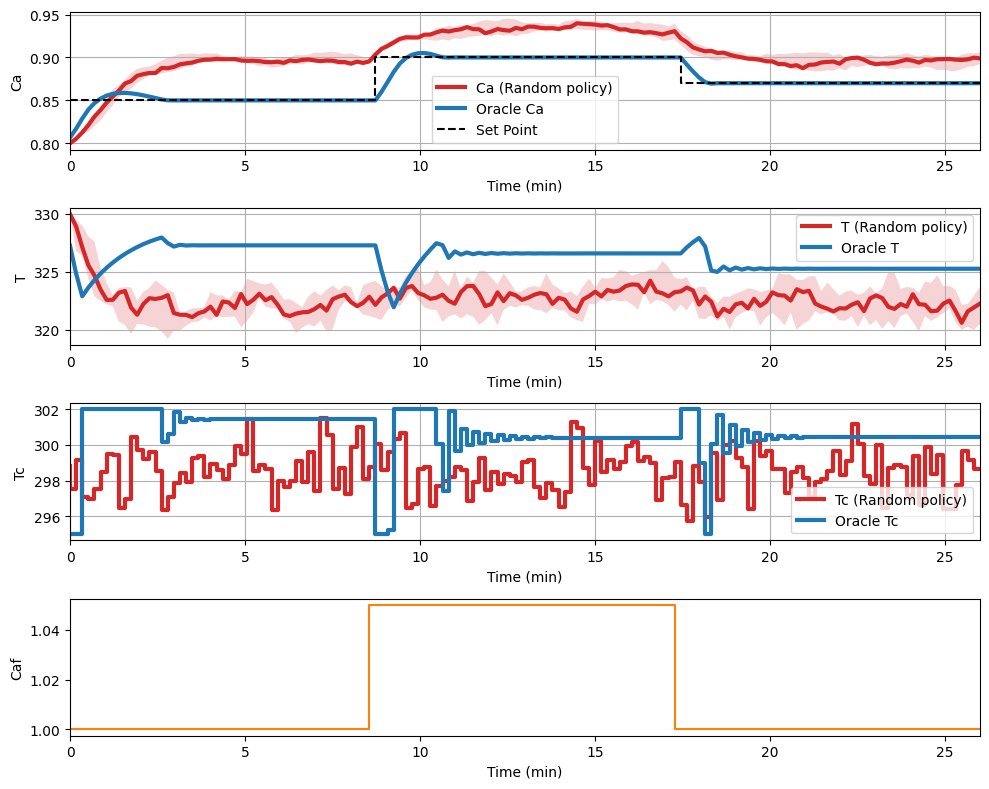

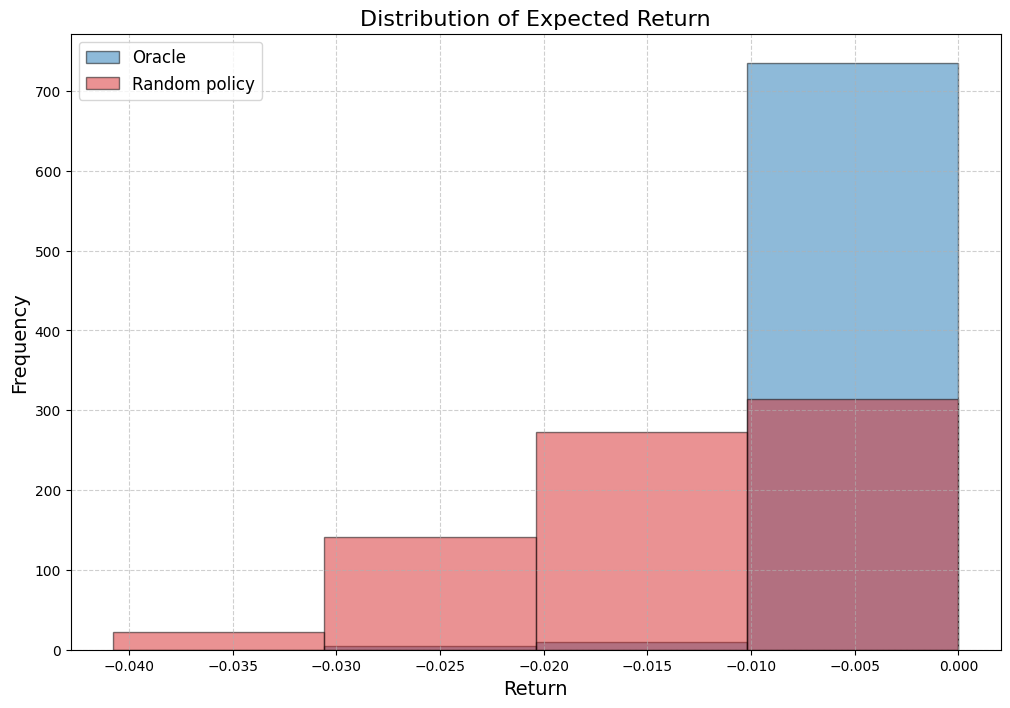

In [4]:
"""
3. Example Policy and Rollout
An example policy which returns an action from an uniform distribution between the upper and lower control bounds.
$\pi = \mathcal U(u_{lb},u_{ub})$
"""

class policy:
    def predict(self,deterministic = False):
        return random.uniform(-1, 1), 0

"""Rollout random policy using the `plot_rollout` method which plots the rollout of the policy, and returns the rollout data and evaluator class. The policy can be plotted with an oracle (MPC with perfect model) which gives you a indication about the optimal control trajectory may look like. Note you can also intract with the environment like you would with any OpenAI gym :)."""

# Suppress output for cleaner execution
# original_stdout = sys.stdout
# original_stderr = sys.stderr
# sys.stdout = open(os.devnull, 'w')
# sys.stderr = open(os.devnull, 'w')

# Run
data, eval = env.plot_rollout({'Random policy':policy}, reps = 5, oracle = True, dist_reward=True,)

# Re-enable output
# sys.stdout = original_stdout
# sys.stderr = original_stderr


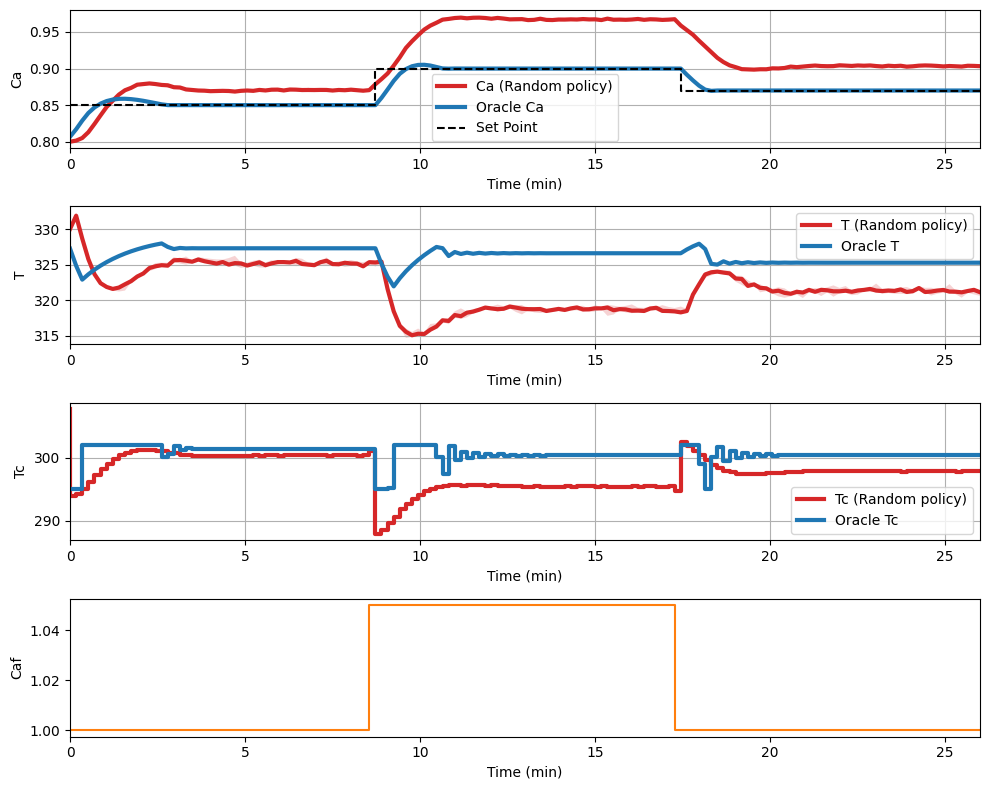

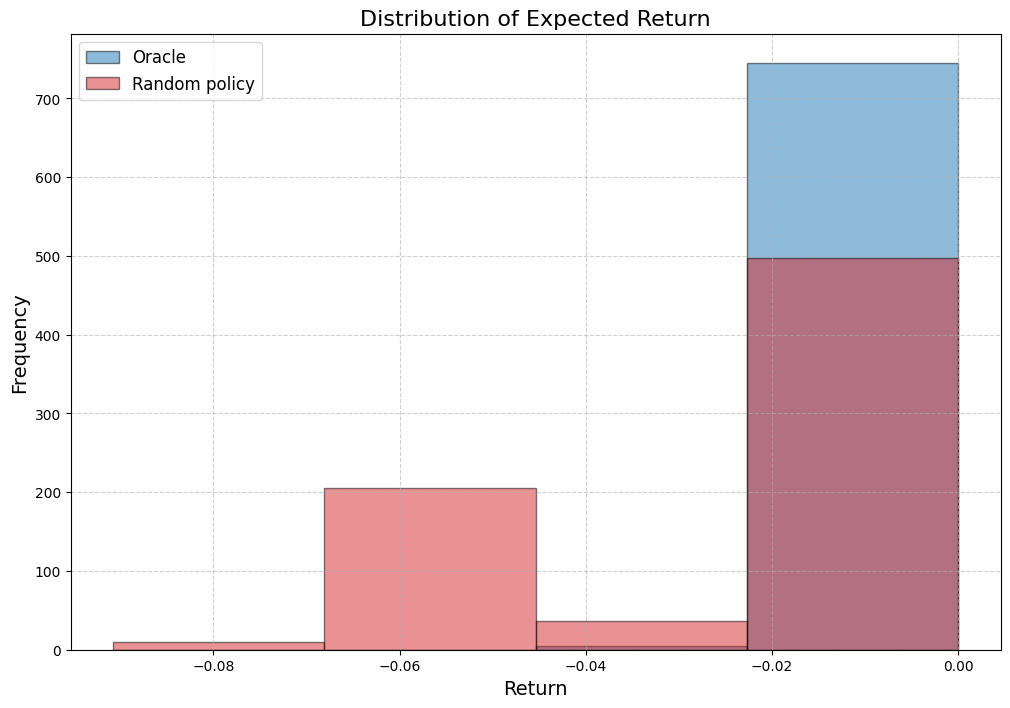

In [5]:

"""
3. Your Implementation!
Some helpful resourses:
  - [Stable Baselines](https://stable-baselines3.readthedocs.io/en/master/) - Off the shelf implementations of common RL algorithms
 -  [Minimal RL ](https://github.com/seungeunrho/minimalRL) - Minimal versions of common RL algorithms (useful for understanding how to translate the algorithms into code)
 -  [Spinning Up in DRL](https://spinningup.openai.com/en/latest/index.html) - More implememtations from OpenAI
 - [Gymnasium](https://gymnasium.farama.org/) - The environment framework which pc-gym is built on
 - [pc-gym documentation](https://maximilianb2.github.io/pc-gym/) - The docs!
"""

# Implement your RL algorithm  here! (We've Implemented a simple proportional controller to get you started)
class your_policy:
    def __init__(self) -> None:
        pass
    def predict(s,deterministic = False):
        kp = 2
        u = -2*kp*(s[2] - s[0])
        return u, s

# Run
data, eval = env.plot_rollout({'Random policy': your_policy}, reps = 5, oracle = True, dist_reward=True,)

In [6]:
# # Hyper parameter optimization with Optuna

# # Suppress output for evaluate_policy and model.learn
# @contextmanager
# def suppress_output():
#     with open(os.devnull, 'w') as devnull:
#         old_stdout = sys.stdout
#         old_stderr = sys.stderr
#         try:
#             sys.stdout = devnull
#             sys.stderr = devnull
#             yield
#         finally:
#             sys.stdout = old_stdout
#             sys.stderr = old_stderr

# def linear_schedule(initial_lr, final_lr):
#     return lambda progress_remaining: progress_remaining * (initial_lr - final_lr) + final_lr

# def optimize_ddpg(trial):
#     # Define the hyperparameter search space
#     buffer_size = trial.suggest_int("buffer_size", 500, 2000, step=500)
#     learning_starts = trial.suggest_int("learning_starts", 5, 20, step=1)
#     batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
#     tau = trial.suggest_float("tau", 0.001, 0.01, step=0.001)
#     gamma = trial.suggest_float("gamma", 0.95, 0.9999)
#     sigma = trial.suggest_float("sigma", 0.1, 0.5, step=0.05)
#     theta = trial.suggest_float("theta", 0.1, 0.4, step=0.05)
#     dt = trial.suggest_float("dt", 0.001, 0.05)
#     initial_lr = trial.suggest_float("initial_lr", 0.001, 0.003, step=0.0001)
#     final_lr = trial.suggest_float("final_lr", 0.0005, 0.001, step=0.0001)
#     nsteps_learning = trial.suggest_int("nsteps_learning", 10000, 50000, step=5000)

#     # Define the action noise
#     n_actions = env.action_space.shape[-1]
#     action_noise = OrnsteinUhlenbeckActionNoise(
#         mean=np.zeros(n_actions),
#         sigma=sigma * np.ones(n_actions),
#         theta=theta,
#         dt=dt
#     )

#     # Save path for evaluation
#     save_path = f"/content/best_model_trial_{trial.number}/"
#     os.makedirs(save_path, exist_ok=True)

#     eval_callback = EvalCallback(
#         eval_env=env,
#         best_model_save_path=save_path,
#         log_path=save_path,
#         eval_freq=nsteps_learning // 10,  # Reduced frequency for less evaluations
#         deterministic=True,
#         render=False
#     )

#     # Instantiate the DDPG model
#     model = DDPG(
#         "MlpPolicy",
#         env,
#         verbose=0,
#         learning_rate=linear_schedule(initial_lr, final_lr),
#         action_noise=action_noise,
#         buffer_size=buffer_size,
#         learning_starts=learning_starts,
#         batch_size=batch_size,
#         tau=tau,
#         gamma=gamma,
#     )

#     # Train the model
#     with suppress_output():
#         model.learn(total_timesteps=nsteps_learning, callback=eval_callback)

#     # Evaluate the model
#     with suppress_output():
#         mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

#     # Return the mean reward (Optuna maximizes the objective)
#     return mean_reward

# # Create an Optuna study
# study = optuna.create_study(direction="maximize")
# study.optimize(optimize_ddpg, n_trials=100)

# # Print the best hyperparameters
# print("Best hyperparameters:", study.best_params)

In [7]:
# RL training with DDPG

# Example of how to train an RL policy with the DDPG algorithm using the Stable Baselines 3 package

# We got from the Optuna optimisation:
# {buffer_size': 1500, 'learning_starts': 16, 'batch_size': 128, 'tau': 0.006, 'gamma': 0.961239294568761,
# 'sigma': 0.25, 'theta': 0.4, 'dt': 0.028517525751839627,
# 'initial_lr': 0.0011, 'final_lr': 0.0007, 'nsteps_learning': 35000}.

# Global timesteps (total number of steps):
nsteps_learning = 35000

# Define the action space bounds. You can get the action space bounds from the environment
n_actions = env.action_space.shape[-1]

# DDPG is an off-policy, deterministic algorithm, which means the policy outputs the same action
# for a given state during training unless noise is explicitly added.
# Action noise encourages exploration, helping the agent learn better policies.
action_noise = OrnsteinUhlenbeckActionNoise(
    mean=np.zeros(n_actions),
    sigma=0.25 * np.ones(n_actions),  # Adjust exploration magnitude
    theta=0.4,                       # Adjust reversion speed
    dt=0.028517525751839627           # Fine-tune time steps
)

# Define a learning rate decay schedule (ex. linear)
def linear_schedule(progress):
    # Progress goes from 1 (start) to 0 (end)
    initial_lr = 0.0011
    final_lr =  0.0007
    return progress * (initial_lr - final_lr) + final_lr

# Custom parameters for DDPG
custom_params = {
    "buffer_size": 1500,
    "learning_starts": 16,                 # When to start learning
    "batch_size": 128,
    "tau": 0.006,                         # Target network update factor
    "gamma": 0.961239294568761            # Discount factor for rewards
}

# Directory for saving the best model
save_path = "/content/best_model/"
os.makedirs(save_path, exist_ok=True)

# Callback for saving the best model
eval_callback = EvalCallback(
    eval_env=env,        # Use the same environment for evaluation
    best_model_save_path=save_path,
    log_path=save_path,
    eval_freq=100,       # Evaluate every 100 steps
    deterministic=True,  # Use deterministic policy during evaluation
    render=False         # Disable rendering during evaluation
)

# Instantiate the DDPG model
DDPG_CSTR = DDPG(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=linear_schedule,  # Pass the schedule function here
    seed=seed,                      # Use a fixed seed for reproducibility
    action_noise=action_noise,      # Add Ornstein-Uhlenbeck action noise
    buffer_size=custom_params["buffer_size"],
    learning_starts=custom_params["learning_starts"],
    batch_size=custom_params["batch_size"],
    tau=custom_params["tau"],
    gamma=custom_params["gamma"],
)

# Train the model with the evaluation callback
DDPG_CSTR.learn(total_timesteps=int(nsteps_learning), callback=eval_callback)

# Print the path where the best model was saved
print(f"Best model saved at: {save_path}/best_model.zip")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\davib\Downloads\EQE778_Trabalho_RL\.venv\Lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\davib\Downloads\EQE778_Trabalho_RL\.venv\Lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
c:\Users\davib\Downloads\EQE778_Trabalho_RL\.venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=100, episode_reward=-2.68 +/- 0.01
Episode length: 149.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 149      |
|    mean_reward     | -2.68    |
| time/              |          |
|    total_timesteps | 100      |
| train/             |          |
|    actor_loss      | 0.018    |
|    critic_loss     | 0.000116 |
|    learning_rate   | 0.0011   |
|    n_updates       | 83       |
---------------------------------
New best mean reward!
Eval num_timesteps=200, episode_reward=-3.15 +/- 0.01
Episode length: 149.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 149      |
|    mean_reward     | -3.15    |
| time/              |          |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | 0.0217   |
|    critic_loss     | 1.97e-05 |
|    learning_rate   | 0.0011   |
|    n_updates       | 183      |
------------------------

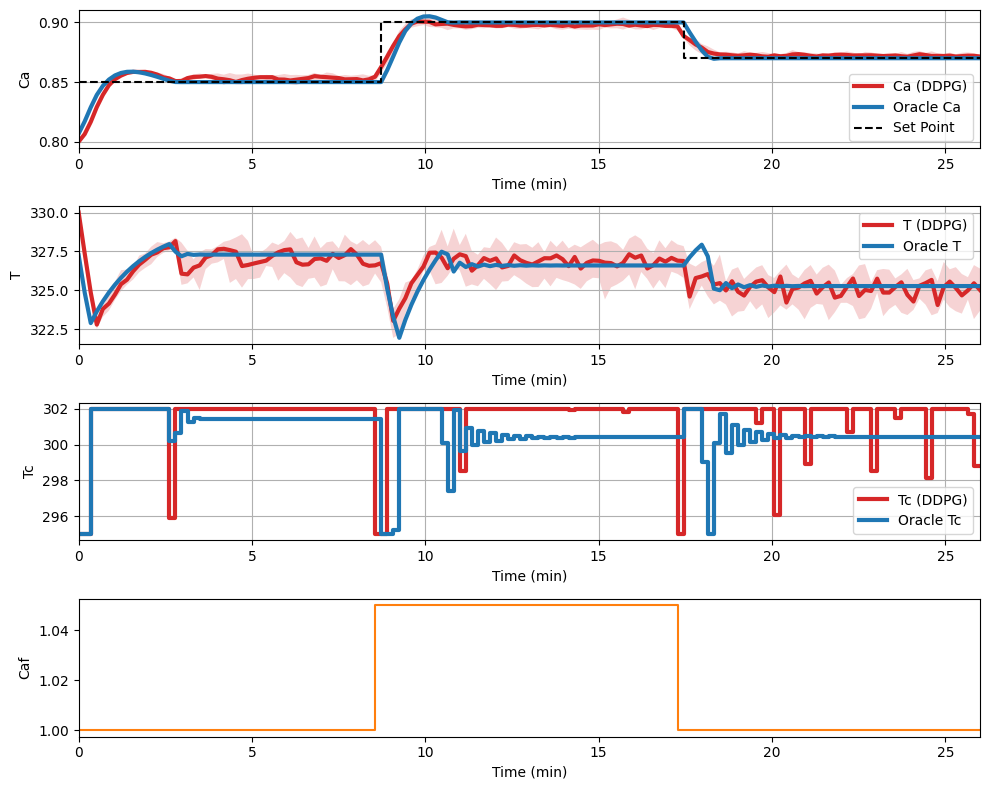

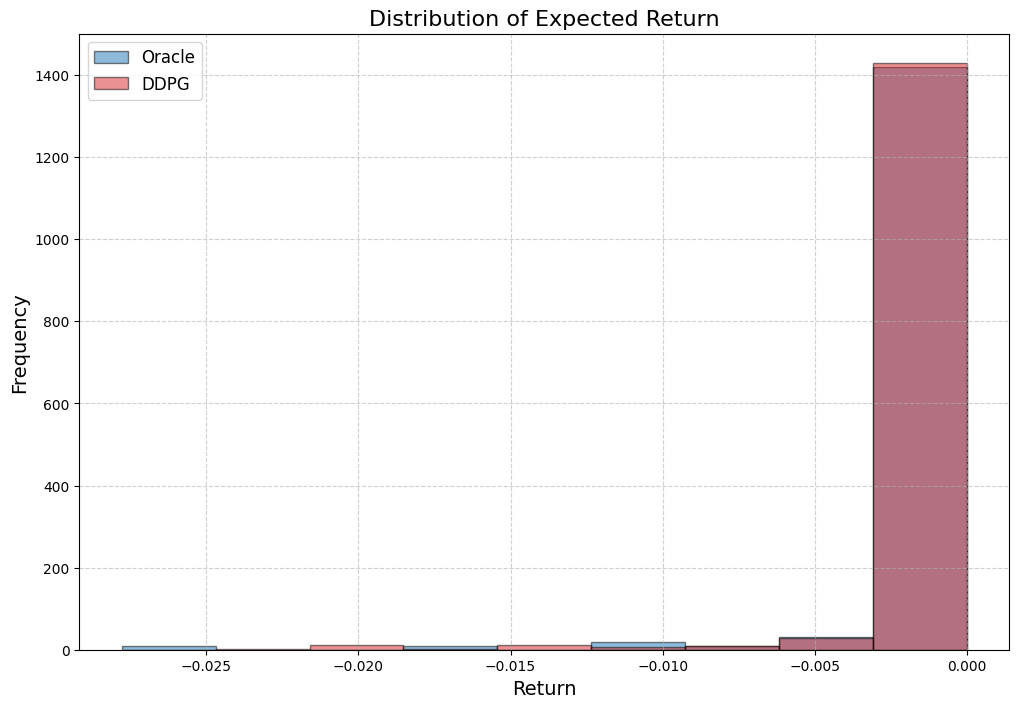

In [8]:
""" 4. Results and Evaluation """

# Load the best model after training
best_model = DDPG.load(f"{save_path}/best_model.zip")
evaluator, data = env.plot_rollout({'DDPG': best_model}, reps = 10, oracle = True, dist_reward=True,)

# data

In [9]:
"""### Your score!"""

res = data['DDPG']['r'].mean()
print(f"Your final score is: {res:.6f} (larger the better).")

Your final score is: -0.000665 (larger the better).


In [10]:
#data['DDPG']['Ca'].mean()